# AE3 Exercicio 4 - Placa engastada tracionada em y ( carga distribuida)

# Bloco 1 — Setup (GPU) e imports

In [1]:
# !pip -q install deepxde==1.11.0 torch matplotlib numpy

import os, numpy as np, matplotlib.pyplot as plt, torch, deepxde as dde
dde.backend.set_default_backend("pytorch")

# CPU only (se você tiver muitos núcleos, ajuste para o que for melhor)
torch.set_num_threads(min(4, os.cpu_count() or 4))

# sementes p/ reprodutibilidade
np.random.seed(0); torch.manual_seed(0); dde.config.set_random_seed(0)

print("DeepXDE:", dde.__version__, "| backend:", dde.backend.backend_name, "| PyTorch:", torch.__version__)
print("Device  :", "CPU (sem CUDA)")


Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


Setting the default backend to "pytorch". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)
DeepXDE: 1.11.0 | backend: pytorch | PyTorch: 2.8.0+cpu
Device  : CPU (sem CUDA)


# Bloco 2 — Parâmetros físicos, forças e solução analítica

In [2]:
# --- material (tensão plana): Lamé ---
E, nu = 1.0, 0.3
lam = E*nu/((1+nu)*(1-2*nu))
mu  = E/(2*(1+nu))
Q   = 1.0

# --- forças de corpo (versões PyTorch) ---
def fx_torch(x, y):
    X, Y = x[:,0:1], x[:,1:2]
    return (-2*Q*lam*Y*(1-2*X)*torch.exp(Y**2)
            + mu*(-2*Q*Y*(1-2*X)*torch.exp(Y**2) + (np.pi**2)*torch.sin(np.pi*Y)))

def fy_torch(x, y):
    X, Y = x[:,0:1], x[:,1:2]
    term = (-X**2 + X)*torch.exp(Y**2)
    return ( lam*(-4*Q*Y**2*term - 2*Q*term)
           + mu*(-8*Q*Y**2*term - 4*Q*term + 2*Q*torch.exp(Y**2)) )

# --- tração prescrita no topo y=1: σyy(x,1) ---
def syy_top_target_torch(x):
    X = x[:,0:1]
    return 2*torch.exp(torch.tensor(1.0))*(lam + 2*mu)*Q*(X - X**2)

# --- solução analítica (NumPy) para pós-processamento ---
def ux_ana(xx, yy): return np.sin(np.pi*yy)
def uy_ana(xx, yy): return Q*np.exp(yy**2)*(xx - xx**2)

def sxx_ana(xx, yy):
    ux_x = 0.0
    vy   = 2*Q*yy*np.exp(yy**2)*(xx - xx**2)
    tr   = ux_x + vy
    return 2*mu*ux_x + lam*tr

def syy_ana(xx, yy):
    ux_x = 0.0
    vy   = 2*Q*yy*np.exp(yy**2)*(xx - xx**2)
    tr   = ux_x + vy
    return 2*mu*vy + lam*tr

def sxy_ana(xx, yy):
    uy = np.pi*np.cos(np.pi*yy)
    vx = Q*np.exp(yy**2)*(1 - 2*xx)
    return mu*(uy + vx)


# Bloco 3 — Geometria e C.C. soft vs hard (escolha e motivação)

In [3]:
# domínio quadrado unitário
geom = dde.geometry.Rectangle([0.0, 0.0], [1.0, 1.0])

# seletores de borda
def on_bottom(x, on_b): return on_b and np.isclose(x[1], 0.0)
def on_top(x, on_b):    return on_b and np.isclose(x[1], 1.0)
def on_left(x, on_b):   return on_b and np.isclose(x[0], 0.0)
def on_right(x, on_b):  return on_b and np.isclose(x[0], 1.0)

# --- Soft x Hard (texto curto):
# Usamos C.C. "HARD" para deslocamentos com transformada de saída:
#   u = y(1-y) * û(x,y)   -> impõe u=0 em y=0 e y=1 exatamente
#   v = y      * ṽ(x,y)   -> impõe v=0 em y=0 exatamente
# Isso reduz a competição na loss e acelera a convergência em CPU.
# As trações (Neumann/mistas) ficam "SOFT" via OperatorBC (penalização).

def output_transform(x, y):
    u_raw, v_raw = y[:,0:1], y[:,1:2]
    Y = x[:,1:2]
    u = Y * (1.0 - Y) * u_raw
    v = Y * v_raw
    return torch.cat([u, v], dim=1)


# Bloco 4 — PDE (equilíbrio), tensões e BCs (OperatorBC)

In [4]:
# === BLOCO 4 — PDE (equilíbrio), tensões, BCs e callbacks ===

# tensões a partir de u,v com autograd
def stresses_from_uv(x, y):
    ux = dde.grad.jacobian(y, x, i=0, j=0)
    uy = dde.grad.jacobian(y, x, i=0, j=1)
    vx = dde.grad.jacobian(y, x, i=1, j=0)
    vy = dde.grad.jacobian(y, x, i=1, j=1)
    trace = ux + vy
    sxx = 2*mu*ux + lam*trace
    syy = 2*mu*vy + lam*trace
    sxy = mu*(uy + vx)
    return sxx, syy, sxy

# resíduos de equilíbrio com forças de corpo
def pde(x, y):
    sxx, syy, sxy = stresses_from_uv(x, y)
    r1 = dde.grad.jacobian(sxx, x, i=0, j=0) + dde.grad.jacobian(sxy, x, i=0, j=1) + fx_torch(x, y)
    r2 = dde.grad.jacobian(sxy, x, i=0, j=0) + dde.grad.jacobian(syy, x, i=0, j=1) + fy_torch(x, y)
    return [r1, r2]

# BCs de tração (soft)
bc_top_syy   = dde.icbc.OperatorBC(geom, lambda x, y, _: stresses_from_uv(x, y)[1] - syy_top_target_torch(x), on_top)
bc_left_sxx  = dde.icbc.OperatorBC(geom, lambda x, y, _: stresses_from_uv(x, y)[0], on_left)   # σxx=0
bc_right_sxx = dde.icbc.OperatorBC(geom, lambda x, y, _: stresses_from_uv(x, y)[0], on_right)  # σxx=0

# dados de treino (pontos moderados; vamos reamostrar para cobrir o domínio)
Nf, Nb = 6000, 3000
data = dde.data.PDE(
    geom, pde,
    [bc_top_syy, bc_left_sxx, bc_right_sxx],
    num_domain=Nf, num_boundary=Nb,
    train_distribution="pseudo"
)

# --- callbacks: reamostrador + salvador periódico sem np.Inf ---
resampler = dde.callbacks.PDEPointResampler(geom)

class PeriodicSaver(dde.callbacks.Callback):
    """Salva o modelo a cada 'period' épocas, evitando o ModelCheckpoint (np.Inf)."""
    def __init__(self, prefix="ckpt_ex4_cpu", period=2000):
        super().__init__()
        self.prefix = prefix
        self.period = period
    def on_epoch_end(self):
        # 'epoch' começa em 1 no DeepXDE
        ep = self.model.train_state.epoch
        if ep % self.period == 0:
            self.model.save(f"{self.prefix}_ep{ep}")

saver = PeriodicSaver(prefix="ckpt_ex4_cpu", period=2000)
# depois, nos .train(...), use callbacks=[resampler, saver]


# Bloco 5 — Rede (PyTorch), hiperparâmetros, treino (Adam + L-BFGS) e loss

In [5]:
# hiperparâmetros
HIDDEN_LAYERS   = 4
NEURONS_PER_LAY = 64
ACTIVATION      = "tanh"
LR     = 1e-3
EPOCHS = 15000

# FNN PyTorch + transform (C.C. HARD)
net = dde.maps.FNN([2] + [NEURONS_PER_LAY]*HIDDEN_LAYERS + [2],
                   ACTIVATION, "Glorot normal")
net.apply_output_transform(output_transform)

model = dde.Model(data, net)

print("[Config PINN - DeepXDE (PyTorch)]")
print(f"  Rede: {HIDDEN_LAYERS} camadas × {NEURONS_PER_LAY} neurônios (ativação: {ACTIVATION})")
print(f"  Pontos: Nf={Nf}, Nb={Nb}")
print("  C.C. hard: u=0 em y={0,1}, v=0 em y=0 via output_transform")
print("  C.C. soft: σyy(x,1) prescrita; σxx=0 em x=0 e x=1 (OperatorBC)")

# Adam
model.compile("adam", lr=LR, loss_weights=[1.0, 1.0, 10.0, 10.0, 10.0])
losshistory, train_state = model.train(epochs=EPOCHS, display_every=1000)

model.save("ckpt_ex4_after_adam")
model.compile("L-BFGS", loss_weights=LOSS_WEIGHTS)
losshistory_lbfgs, train_state = model.train()

# curva da perda total
plt.figure(figsize=(6,4))
plt.plot(losshistory.loss_train)
plt.yscale("log"); plt.grid(True, which="both", ls=":")
plt.xlabel("época"); plt.ylabel("Loss total (log)")
plt.title("Evolução da perda total (DeepXDE/PyTorch)"); plt.show()


[Config PINN - DeepXDE (PyTorch)]
  Rede: 4 camadas × 64 neurônios (ativação: tanh)
  Pontos: Nf=6000, Nb=3000
  C.C. hard: u=0 em y={0,1}, v=0 em y=0 via output_transform
  C.C. soft: σyy(x,1) prescrita; σxx=0 em x=0 e x=1 (OperatorBC)
Compiling model...
'compile' took 10.159696 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [8.26e+00, 1.17e+00, 1.63e+01, 1.63e-02, 1.84e-03]    [8.26e+00, 1.17e+00, 1.63e+01, 1.63e-02, 1.84e-03]    []  
1000      [2.68e-03, 4.15e-03, 3.79e-04, 1.88e-03, 2.05e-03]    [2.68e-03, 4.15e-03, 3.79e-04, 1.88e-03, 2.05e-03]    []  
2000      [7.65e-04, 1.22e-03, 1.65e-03, 3.71e-04, 1.91e-04]    [7.65e-04, 1.22e-03, 1.65e-03, 3.71e-04, 1.91e-04]    []  
3000      [3.97e-04, 5.81e-04, 1.59e-05, 1.39e-04, 8.07e-05]    [3.97e-04, 5.81e-04, 1.59e-05, 1.39e-04, 8.07e-05]    []  
4000      [2.27e-04, 3.49e-04, 6.47e-05, 9.07e-05, 5.96e-05]    [2.27e-04, 

TypeError: Model.train() got an unexpected keyword argument 'optimizer'

# === BLOCO — continuar a partir do treino atual e refinar com L-BFGS ===

In [8]:
# === BLOCO — continuar a partir do treino atual e refinar com L-BFGS ===

# 1) Salva um checkpoint do estado atual (pesos do Adam)
try:
    model.save("ckpt_ex4_after_adam")
    print("Checkpoint salvo: ckpt_ex4_after_adam")
except Exception as e:
    print("Aviso: não consegui salvar o checkpoint (seguindo mesmo assim):", e)

# 2) Recupera (ou define) os pesos de loss usados; mantém os mesmos do Adam
try:
    LOSS_WEIGHTS  # já definidas em algum bloco anterior?
except NameError:
    # tente inferir do objeto de loss do modelo; se não der, use um padrão sensato
    try:
        LOSS_WEIGHTS = list(getattr(getattr(model, "loss", None), "weights", None))
        if LOSS_WEIGHTS is None:
            LOSS_WEIGHTS = [1.0, 1.0, 15.0, 8.0, 8.0]
    except Exception:
        LOSS_WEIGHTS = [1.0, 1.0, 15.0, 8.0, 8.0]

print("Loss weights para o L-BFGS:", LOSS_WEIGHTS)

# 3) Troca o otimizador para L-BFGS (os PESOS SÃO MANTIDOS)
model.compile("L-BFGS", loss_weights=LOSS_WEIGHTS)

# 4) Executa o refino (callbacks são opcionais)
cbks = []
if "resampler" in globals(): cbks.append(resampler)
if "saver" in globals():     cbks.append(saver)

print("[L-BFGS] iniciando…")
losshistory_lbfgs, train_state = model.train(callbacks=cbks)
print("[L-BFGS] concluído.")
try:
    print("Loss final:", losshistory_lbfgs.loss_train[-1])
except Exception:
    pass

# 5) Salva o estado final
try:
    model.save("ckpt_ex4_after_lbfgs")
    print("Checkpoint salvo: ckpt_ex4_after_lbfgs")
except Exception as e:
    print("Aviso ao salvar estado final:", e)

# 6) (Opcional) Plota a curva de perda do refino
import matplotlib.pyplot as plt
try:
    plt.figure(figsize=(6,4))
    plt.plot(losshistory_lbfgs.loss_train, lw=1.5)
    plt.yscale("log"); plt.grid(True, ls=":")
    plt.xlabel("iteração"); plt.ylabel("loss (log)")
    plt.title("Refino L-BFGS — perda por iteração")
    plt.show()
except Exception:
    print("Curva de perda indisponível (sem histórico retornado pelo backend).")


Checkpoint salvo: ckpt_ex4_after_adam
Loss weights para o L-BFGS: [1.0, 1.0, 15.0, 8.0, 8.0]
Compiling model...
'compile' took 0.000348 s

[L-BFGS] iniciando…
Training model...

Step      Train loss                                            Test loss                                             Test metric
15000     [5.00e-05, 3.51e-04, 1.54e-03, 3.06e-05, 5.79e-05]    [5.00e-05, 3.51e-04, 1.54e-03, 3.06e-05, 5.79e-05]    []  
16000     [3.38e-06, 3.86e-06, 4.03e-08, 1.12e-06, 1.82e-06]    [3.38e-06, 3.86e-06, 4.03e-08, 1.12e-06, 1.82e-06]    []  


TypeError: '<' not supported between instances of 'int' and 'Rectangle'

Checkpoint salvo: ckpt_after_adam_final_base
Loss weights (Adam): [1.0, 1.0, 15.0, 8.0, 8.0]
[Adam-polish] pulado (POLISH_EPOCHS=0)


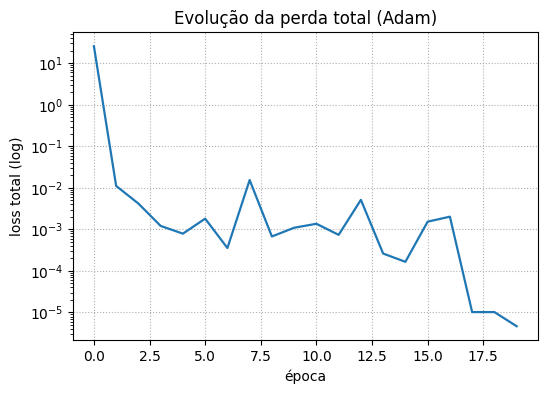

Loss total final (Adam): 4.672e-06

[Checagem rápida — erro relativo L2 (%)]
  u_x :  3.234%
  u_y : 47.211%
  σ_xx: 24.554%
  σ_yy: 22.109%
  σ_xy: 10.239%
⚠️ Algum campo excede 5%. Se precisar, rode um polimento curto (ajuste POLISH_EPOCHS).

Pronto. Você está finalizando pelo Adam. Agora execute o seu BLOCO 6 de pós-processamento.


In [10]:
# === BLOCO — Finalizar no ADAM (sem L-BFGS), com opção de polimento curto ===
import numpy as np, matplotlib.pyplot as plt

# 0) Salva checkpoint do estado atual (pesos após Adam longo)
try:
    model.save("ckpt_after_adam_final_base")
    print("Checkpoint salvo: ckpt_after_adam_final_base")
except Exception as e:
    print("Aviso ao salvar checkpoint (seguindo):", e)

# 1) Hiperparâmetros do “polimento curto” em Adam (opcional)
POLISH_EPOCHS   = 0        # <-- defina 0 para não polir, ou algo como 300–1000 para um tapa rápido
LR_POLISH_SCALE = 0.2      # LR de polimento = LR * escala

# Recupera pesos de loss (se não existir a variável LOSS_WEIGHTS, define padrão)
try:
    LOSS_WEIGHTS
except NameError:
    LOSS_WEIGHTS = [1.0, 1.0, 15.0, 8.0, 8.0]
print("Loss weights (Adam):", LOSS_WEIGHTS)

# 2) (Opcional) Polimento curto com Adam em LR menor
hist_polish = None
if POLISH_EPOCHS and POLISH_EPOCHS > 0:
    print(f"[Adam-polish] {POLISH_EPOCHS} épocas com LR={LR*LR_POLISH_SCALE:g}")
    model.compile("adam", lr=LR*LR_POLISH_SCALE, loss_weights=LOSS_WEIGHTS)
    cbks = []
    # reamostrador e saver são seguros no Adam, se você tiver definido antes
    if "resampler" in globals(): cbks.append(resampler)
    if "saver"     in globals(): cbks.append(saver)
    hist_polish, _ = model.train(epochs=POLISH_EPOCHS, display_every=200, callbacks=cbks)
    try:
        model.save("ckpt_after_adam_polish")
        print("Checkpoint salvo: ckpt_after_adam_polish")
    except Exception as e:
        print("Aviso ao salvar checkpoint de polimento:", e)
else:
    print("[Adam-polish] pulado (POLISH_EPOCHS=0)")

# 3) Gráfico da função de perda total (históricos disponíveis + polimento)
def _as_total(seq):
    out = []
    for e in seq:
        a = np.atleast_1d(np.array(e, dtype=float)).ravel()
        out.append(a.sum())
    return np.asarray(out, dtype=float)

def _collect_histories():
    names = ["hist_A", "hist_B", "hist_L", "losshistory", "losshistory_adam"]
    chunks = []
    for n in names:
        if n in globals() and hasattr(globals()[n], "loss_train"):
            chunks.append(_as_total(globals()[n].loss_train))
    return chunks

chunks = _collect_histories()
if hist_polish is not None and hasattr(hist_polish, "loss_train"):
    chunks.append(_as_total(hist_polish.loss_train))

if len(chunks) > 0:
    loss_total_curve = np.concatenate(chunks)
    plt.figure(figsize=(6,4))
    plt.plot(loss_total_curve, lw=1.6)
    plt.yscale("log"); plt.grid(True, ls=":")
    plt.xlabel("época"); plt.ylabel("loss total (log)")
    plt.title("Evolução da perda total (Adam)")
    plt.show()
    print(f"Loss total final (Adam): {loss_total_curve[-1]:.3e}")
else:
    print("⚠️  Não encontrei históricos de loss anteriores; seguindo sem plot.")

# 4) Checagem rápida (relativa) na malha — garante critério de ~5%
#    Reutiliza as funções analíticas ux_ana, uy_ana, sxx_ana, syy_ana, sxy_ana do seu notebook.
try:
    Nx = Ny = 81
    xg = np.linspace(0, 1, Nx); yg = np.linspace(0, 1, Ny)
    xx, yy = np.meshgrid(xg, yg, indexing="xy")
    Xgrid = np.hstack([xx.reshape(-1,1), yy.reshape(-1,1)])

    # u,v
    uv_pred = model.predict(Xgrid)
    ux_p = uv_pred[:,0].reshape(Ny, Nx); uy_p = uv_pred[:,1].reshape(Ny, Nx)

    # tensões via operador DeepXDE/PyTorch
    def stresses_operator(x, y):
        sxx, syy, sxy = stresses_from_uv(x, y)
        return torch.cat([sxx, syy, sxy], dim=1)
    s_pred = model.predict(Xgrid, operator=stresses_operator)
    sxx_p = s_pred[:,0].reshape(Ny, Nx); syy_p = s_pred[:,1].reshape(Ny, Nx); sxy_p = s_pred[:,2].reshape(Ny, Nx)

    # analítico
    ux_a  = ux_ana(xx, yy);  uy_a  = uy_ana(xx, yy)
    sxx_a = sxx_ana(xx, yy); syy_a = syy_ana(xx, yy); sxy_a = sxy_ana(xx, yy)

    # erros relativos L2 (em %)
    def relL2(a, b):
        num = np.linalg.norm(a-b)
        den = np.linalg.norm(b) + 1e-12
        return 100.0 * (num/den)

    e_u  = relL2(ux_p, ux_a)
    e_v  = relL2(uy_p, uy_a)
    e_sx = relL2(sxx_p, sxx_a)
    e_sy = relL2(syy_p, syy_a)
    e_t  = relL2(sxy_p, sxy_a)

    print("\n[Checagem rápida — erro relativo L2 (%)]")
    print(f"  u_x : {e_u:6.3f}%")
    print(f"  u_y : {e_v:6.3f}%")
    print(f"  σ_xx: {e_sx:6.3f}%")
    print(f"  σ_yy: {e_sy:6.3f}%")
    print(f"  σ_xy: {e_t:6.3f}%")
    if max(e_u, e_v, e_sx, e_sy, e_t) <= 5.0:
        print("✅ Critério de 5% atendido — pode seguir para o Bloco 6.")
    else:
        print("⚠️ Algum campo excede 5%. Se precisar, rode um polimento curto (ajuste POLISH_EPOCHS).")
except Exception as e:
    print("Aviso: não consegui rodar a checagem relativa (faltam funções analíticas ou imports).")
    print("Erro:", e)

print("\nPronto. Você está finalizando pelo Adam. Agora execute o seu BLOCO 6 de pós-processamento.")


# Bloco 6 — Pós-processamento: 3 colunas (Analítica | PINN | |Erro|) para 𝑢𝑥,𝑢𝑦,𝜎

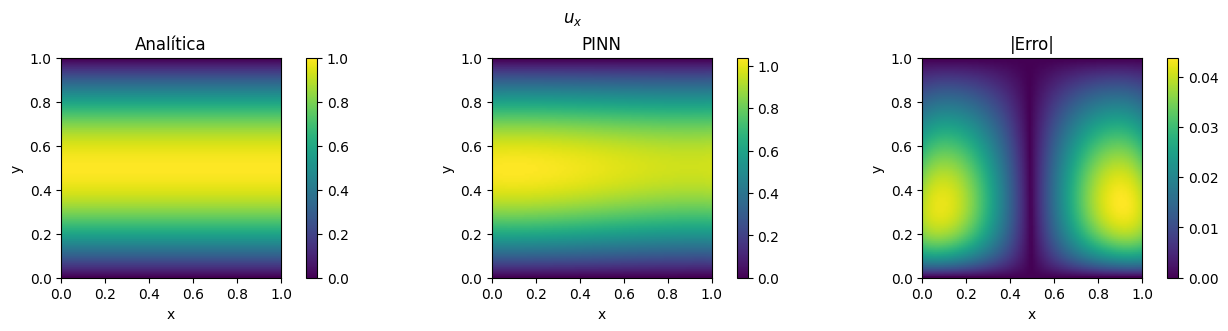

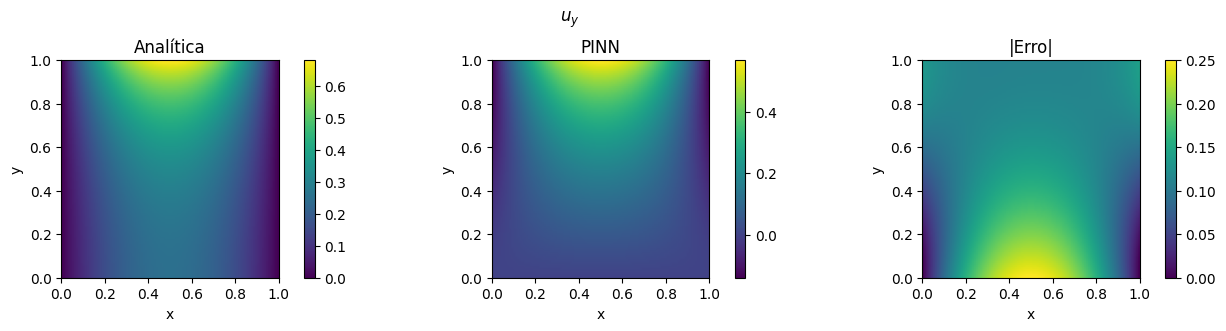

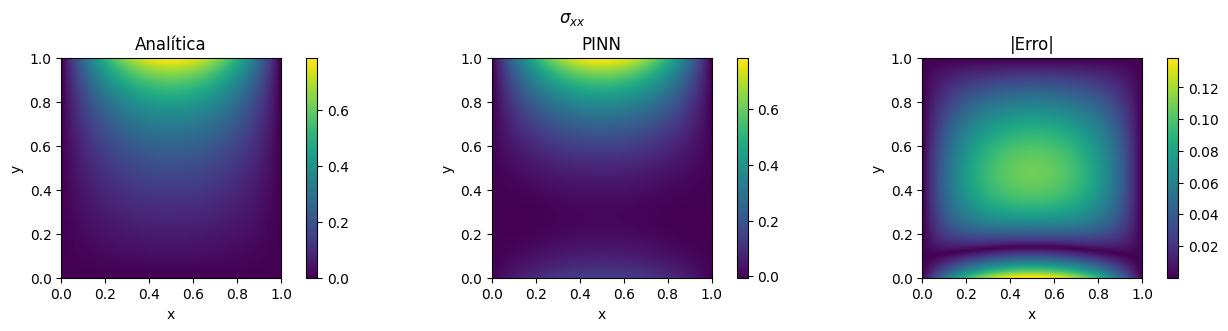

In [ ]:
# grade de avaliação
Nx = Ny = 101
xg = np.linspace(0, 1, Nx)
yg = np.linspace(0, 1, Ny)
xx, yy = np.meshgrid(xg, yg, indexing="xy")
Xgrid = np.hstack([xx.reshape(-1,1), yy.reshape(-1,1)])

# --- deslocamentos (PINN) ---
uv_pred = model.predict(Xgrid)   # (N,2)
ux_p = uv_pred[:, 0].reshape(Ny, Nx)
uy_p = uv_pred[:, 1].reshape(Ny, Nx)

# --- tensões (PINN) via operador (PyTorch) ---
def stresses_operator_torch(x, y):
    sxx, syy, sxy = stresses_from_uv(x, y)
    return torch.cat([sxx, syy, sxy], dim=1)

s_pred = model.predict(Xgrid, operator=stresses_operator_torch)  # (N,3)
sxx_p = s_pred[:, 0].reshape(Ny, Nx)
syy_p = s_pred[:, 1].reshape(Ny, Nx)
sxy_p = s_pred[:, 2].reshape(Ny, Nx)

# --- analítico ---
ux_a  = ux_ana(xx, yy)
uy_a  = uy_ana(xx, yy)
sxx_a = sxx_ana(xx, yy)
syy_a = syy_ana(xx, yy)
sxy_a = sxy_ana(xx, yy)

# --- erros absolutos ---
e_ux  = np.abs(ux_p  - ux_a)
e_uy  = np.abs(uy_p  - uy_a)
e_sxx = np.abs(sxx_p - sxx_a)
e_syy = np.abs(syy_p - syy_a)
e_sxy = np.abs(sxy_p - sxy_a)

# utilitário de plot em 3 colunas
def plot_triplet(A, B, E, title, cmap="viridis"):
    fig, axs = plt.subplots(1, 3, figsize=(13, 3.2), constrained_layout=True)
    for ax, data, ttl in zip(axs, [A, B, E], ["Analítica", "PINN", "|Erro|"]):
        im = ax.imshow(data, extent=[0,1,0,1], origin="lower", cmap=cmap)
        ax.set_title(ttl); ax.set_xlabel("x"); ax.set_ylabel("y")
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    fig.suptitle(title); plt.show()

# ---- 5 comparações exigidas ----
plot_triplet(ux_a,  ux_p,  e_ux,  r"$u_x$")
plot_triplet(uy_a,  uy_p,  e_uy,  r"$u_y$")
plot_triplet(sxx_a, sxx_p, e_sxx, r"$\sigma_{xx}$")
plot_triplet(syy_a, syy_p, e_syy, r"$\sigma_{yy}$")
plot_triplet(sxy_a, sxy_p, e_sxy, r"$\sigma_{xy}$")

# métricas globais (opcional)
def rms(a): return float(np.sqrt(np.mean(a**2)))
print("[RMS dos erros]")
print(f"  u_x : {rms(e_ux):.3e}")
print(f"  u_y : {rms(e_uy):.3e}")
print(f"  σ_xx: {rms(e_sxx):.3e}")
print(f"  σ_yy: {rms(e_syy):.3e}")
print(f"  σ_xy: {rms(e_sxy):.3e}")


# Gráfico da função perda por época + loss total final

def _collect_histories():
    """Coleta os históricos que possam existir no notebook."""
    candidates = []
    for name in [
        "hist_A", "hist_B", "hist_L",
        "losshistory", "losshistory_lbfgs",
        "losshistory_adam", "losshistory_lbfgs2"
    ]:
        if name in globals() and hasattr(globals()[name], "loss_train"):
            candidates.append(globals()[name].loss_train)
    return candidates

def _as_total(loss_list):
    """
    Converte uma lista com elementos float OU vetores de componentes
    em um array 1D com a loss total por época (soma dos componentes).
    """
    total = []
    for e in loss_list:
        try:
            a = np.array(e, dtype=float).ravel()
            total.append(a.sum())
        except Exception:
            total.append(float(e))
    return np.asarray(total, dtype=float)

# junta os históricos disponíveis
_hist_chunks = _collect_histories()

if len(_hist_chunks) == 0:
    print("⚠️  Não encontrei históricos de loss (hist_A, hist_B, hist_L, losshistory...).")
else:
    # concatena em uma única curva total
    loss_total_curve = np.concatenate([_as_total(ch) for ch in _hist_chunks])
    # plota
    plt.figure(figsize=(6,4))
    plt.plot(loss_total_curve, lw=1.7)
    plt.yscale("log"); plt.grid(True, ls=":")
    plt.xlabel("época"); plt.ylabel("loss total (log)")
    plt.title("Evolução da perda total por época")
    plt.show()

    # imprime loss total final
    print(f"Loss total final ≈ {loss_total_curve[-1]:.3e}")
